In [1]:
from PyPRIS import *
import os
print("")
print("")
print("")
print("PyPRIS Continue!")
import warnings
warnings.filterwarnings("ignore")




PyPRIS Continue!


In [2]:
# load the original ticket
ticket = get_ticket('./Go.pris_ticket')

# prep the order according to the ticket
psf = io.imread(ticket.psf_path)
blur1 = io.imread(ticket.plane1_path)
blur2 = io.imread(ticket.plane2_path)
blur = np.concatenate([blur1, blur2],axis=0)

# prepare a observer for pypris. [from one candidate, to one observation]
# summon an observer from the ObserveStation (ObserveStation class) (Cheers~)
observer = ObserveStation()
"configure this observer with biplane observation specifics"
observer.observe_biplane_prep(psf, single_image_size = blur1.shape,
                           deltaz_plane1 = ticket.plane1_dz,
                           deltaz_plane2 = ticket.plane2_dz,
                           psfz0 = ticket.psfz0,
                           observer_debugger = ticket.observer_debugger,
                           observer_edge_padding = ticket.observer_edge_padding)

In [3]:
# Get the latest saved linbreg filename


# put in the file folder where you saved all the linbreg objects.
# path = 'C:\\Users\\wxjpp\\Desktop\\PyPRIS-master\\saved_objects'
path = './saved_objects'

mxnames = []
objIter = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if file.endswith('SensingMx.file'):
            mxnames.append(file[0:-5])


mxName = mxnames[-1]

for r, d, f in os.walk(path):
    for file in f:
        if file.startswith(mxName[0:-9]):
            if not file.endswith('SensingMx.file'):
                objIter.append(int(file[len(mxName[0:-9]):-5]))


objName = mxName[0:-9] + str(max(objIter))

print("Loading LinBreg object from: ")
print(path)
print(mxName)            
print(objName)

# Load the previous saved LinBreg object
with open('{}/{}.file'.format(path, objName), "rb") as f:
    linbreg_ori = pickle.load(f) #the loaded object is a LinBreg object


linbreg = copy.deepcopy(linbreg_ori)

with open('{}/{}.file'.format(path, mxName), "rb") as s:
    linbreg.A = joblib.load(s)


# Create a PyPRIS object and initialize according to the loaded LinBreg object
pypris = PyPRIS()
pypris.current_candidates = linbreg.candidate_coords
pypris.current_candidates_intervals = linbreg.candidate_intervals
pypris.current_A = linbreg.A
pypris.observation = blur.ravel()

# set a check mark for pypris:
pypris.set_check_mark()


# put the configured observer to the pypris to perform the tasks of 'observe_biplane'
# when a pypris object observes, it is through the observer and it is
# done with the observer's observe_biplane skill (skill = method).
pypris.observe = observer.observe_biplane


linbreg_ori.A = 0
Iter = int(linbreg.PyPRIS_iter[4:])
print("---------------- PRIS refinement #" + str(Iter) + " ------------------")
linbreg.go()

Loading LinBreg object from: 
./saved_objects
PyPRIS_bgSCF1.5_mu1.0e+05_alpha1.0e-11_pris2_SensingMx
PyPRIS_bgSCF1.5_mu1.0e+05_alpha1.0e-11_pris2_600000
---------------- PRIS refinement #2 ------------------


In [4]:
with open('PyPRIS_mask.file', "rb") as s:
    mask = joblib.load(s)
    
#linbreg.apply_mask(mask)

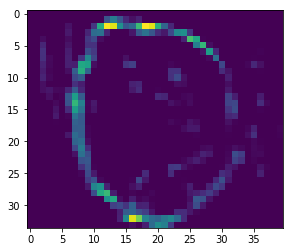

In [5]:
plt.imshow(np.mean(linbreg.candidate_vis(), axis = 0))

In [6]:
for PRIS_iter in np.arange(Iter+1,ticket.PRIS_iter_end):    
    pypris.prep_for_new_refinement()
    pypris.refine_candidates(linbreg)
    pypris.generate_sensing_mx()
    # prepare the inner sparse recovery
    pypris.current_A = pypris.current_A / ticket.psf_norm_factor
    c = np.dot(pypris.observation.ravel(), pypris.current_A)
    c1 = np.min(c[0:-2])
    c2 = np.max(c[0:-2])
    bgv = c1 + (c2 - c1) * ticket.bg_scaling_coef
    pypris.current_A[:, -1] = bgv / np.sum(pypris.observation.ravel())  # the last column in A corresponds to the background component.   
    linbreg = copy.deepcopy(linbreg_ori)
    linbreg.candidate_coords = pypris.current_candidates
    linbreg.candidate_intervals = pypris.current_candidates_intervals
    linbreg.A = pypris.current_A
    linbreg.b = pypris.observation.ravel()
    linbreg.PyPRIS_iter = "pris"+ str(PRIS_iter)
    linbreg.stopping_loghistpercdelres_thres -= PRIS_iter*2
    print("---------------- PRIS refinement #" + str(PRIS_iter) + " ------------------")
    # recover
    linbreg.get_ready()
    linbreg.go()

---------------- PRIS refinement #3 ------------------
stopping threshold is -25
alpha is 1e-11
Successfully created Scratch directory . 
Successfully wrote sensing matrix to directory ./saved_objects 
Successfully created Object-saving directory ./saved_objects 


ValueError: zero-size array to reduction operation minimum which has no identity

In [7]:
pypris.prep_for_new_refinement()
pypris.refine_candidates(linbreg)
pypris.generate_sensing_mx()

In [8]:
pypris.current_A = pypris.current_A / ticket.psf_norm_factor

In [9]:
c = np.dot(pypris.observation.ravel(), pypris.current_A)

In [11]:
c1 = np.min(c[0:-2])
c2 = np.max(c[0:-2])
bgv = c1 + (c2 - c1) * ticket.bg_scaling_coef
pypris.current_A[:, -1] = bgv / np.sum(pypris.observation.ravel())  # the last column in A corresponds to the background component.
linbreg = copy.deepcopy(linbreg_ori)
linbreg.candidate_coords = pypris.current_candidates
linbreg.candidate_intervals = pypris.current_candidates_intervals
linbreg.A = pypris.current_A
linbreg.b = pypris.observation.ravel()
linbreg.PyPRIS_iter = "pris"+ str(Iter)
linbreg.stopping_loghistpercdelres_thres -= Iter*2
print("---------------- PRIS refinement #" + str(Iter) + " ------------------")

---------------- PRIS refinement #2 ------------------


In [12]:
# recover
linbreg.get_ready()

stopping threshold is -23
alpha is 1e-11
Successfully created Scratch directory . 
Successfully wrote sensing matrix to directory ./saved_objects 
Successfully created Object-saving directory ./saved_objects 


In [13]:
linbreg.go()

In [6]:
np.nonzero(pypris.current_A)

(array([    0,     1,     2, ..., 10079, 10080, 10081], dtype=int64),
 array([0, 0, 0, ..., 0, 0, 0], dtype=int64))

In [11]:
def quick_and_dirty_mask_ref(linbreg, pypris, mask):
    maskbreg = copy.deepcopy(linbreg)
    maskbreg.x = maskbreg.candidate_vis_inv(mask)
    maskpris = copy.deepcopy(pypris)
    maskpris.prep_for_new_refinement()
    maskpris.refine_candidates(maskbreg)
    return maskbreg.candidate_vis()

In [5]:
pypris.apply_mask(linbreg, mask)

In [19]:
mask = quick_and_dirty_mask_ref(linbreg,pypris,mask)

IndexError: index 54 is out of bounds for axis 1 with size 34

In [5]:
maskbreg = copy.deepcopy(linbreg)

In [6]:
maskbreg.x = maskbreg.candidate_vis_inv(mask)

In [8]:
maskpris = copy.deepcopy(pypris)
maskpris.prep_for_new_refinement()
maskpris.refine_candidates(maskbreg)

In [10]:
maskbreg.candidate_vis().shape

(71, 34, 40)

In [16]:
mask.shape

(71, 34, 40)

In [18]:
pypris.prep_for_new_refinement()
pypris.refine_candidates(linbreg)

In [17]:
linbreg.candidate_vis().shape

(71, 34, 40)

In [18]:
mask.shape

(71, 34, 40)